###### You may have to download some packages imported

In [1]:
from lxml import html
from bs4 import BeautifulSoup
import requests
import urllib.request
import bs4
import csv
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import math
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm
import pickle
from heapq import heappush, nlargest
import heapq

import ipywidgets as widgets
import parser_utils
import collector_utils
import index_utils
import utils
import main

# 1. Data collection

### 1.1. Get the list of the movies

#We run this comman only once to get the links from movie1-2-3.html and save the list in a file

links = collector_utils.get_links('movies1.html', 'movies2.html', 'movies3.html')

with open('data/links_list.pickle', 'wb') as fp:
    pickle.dump(links, fp)


In [3]:
# take the list from the file created before
with open('data/links_list.pickle', 'rb') as f:
    links = pickle.load(f)

### 1.2. Crawl Wikipedia

In [5]:
# download pages
#Command started only once to download pages
collector_utils.download_pages(links, '../pfj')

100%|██████████| 20/20 [00:09<00:00,  2.21it/s]


### 1.3 Parse downloaded pages 

##### Run this command only once to save tsv files

    p1 = path to .html files

    p2 = path to .tsv files
    
    n_pages = len(links)

    parser_utils.scapper_tsv(n_pages, p1, p2)

##### Create films data frame and save it in a file
    p3 = path where you want to save film_dataFrame
    
    df_films = parser_utils.films_data_frame(links, p2)

    df_films.to_csv(p3 + '/films_dataFrame.csv')

# 2. Search Engine

In [2]:
# read data frame from the file created before
df_films = pd.read_csv('data/films_dataFrame.csv')

### 2.1. Conjunctive query

##### Create vocabulary and save it on a file (only once)

    vocabulary = {}
    
    df_films.apply(index_utils.create_vocabulary, axis=1, voc = vocabulary)
    
    # Store data (serialize)
    
    with open('data/vocabulary.pickle', 'wb') as handle:
        pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)

###### Store data (serialize)

    with open('data/vocabulary.pickle', 'wb') as handle:
        pickle.dump(vocabulary, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 2.1.1/2.2.1 Create your index! / Inverted index

##### Create inverted_index (words_film) (only once)

    words_dict = {}

    df_films['words_number'] = df_films.apply(index_utils.create_inverted_dict, axis=1, 
                            inverted_dict = words_dict, vocabulary = vocabulary)
                            
    df_films.to_csv('data' + '/films_dataFrame.csv')

###### Store data (serialize) (only once)

    with open('data/words_dict.pickle', 'wb') as handle:
        pickle.dump(words_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
# Load vocabulary and inverted index from the files created before
# Load data (deserialize)
with open('data/vocabulary.pickle', 'rb') as handle:
    vocabulary = pickle.load(handle)

with open('data/words_dict.pickle', 'rb') as handle:
    words_dict = pickle.load(handle)
    

### 2.1.2) Execute the query (Search Engine 1)

We use Jupyter Widgets to let the user enter the query

In [4]:
q1 = widgets.Text(
    value='',
    placeholder='Type something',
    description='String:',
    disabled=False
)
q1

Text(value='', description='String:', placeholder='Type something')

In [5]:
# Data frame for Search engine 1
se1 = df_films

# take the value of the query
query1 = q1.value

# Start Engine 1
se1['Engine1'] = se1.apply(main.search_engine_1_apply, axis = 1, 
                           word_dict = words_dict,
                           query = query1, 
                           vocabulary = vocabulary)
se1[se1['Engine1'] == 1][['title','Wikipedia_link', 'intro']].head(15)

,title,Wikipedia_link,intro
13787,Harry Potter and the Philosopher's Stone (film),https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Philosopher's Stone (rele...
13988,Harry Potter and the Chamber of Secrets (film),https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Chamber of Secrets is a 2...
14393,Harry Potter and the Prisoner of Azkaban (film),https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Prisoner of Azkaban is a ...
14590,Harry Potter and the Goblet of Fire (film),https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Goblet of Fire is a 2005 ...
15148,Harry Potter and the Order of the Phoenix (film),https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Order of the Phoenix is a...
15571,Harry Potter and the Half-Blood Prince (film),https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Half-Blood Prince is a 20...
15768,Harry Potter and the Deathly Hallows – Part 1,https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Deathly Hallows – Part 1 ...
15962,Harry Potter and the Deathly Hallows – Part 2,https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Deathly Hallows – Part 2 ...
20949,Harry Potter and the Deathly Hallows – Part 2,https://en.wikipedia.org/wiki/Harry_Potter_and...,Harry Potter and the Deathly Hallows – Part 2 ...


## 2.2) Conjunctive query & Ranking score

In [6]:
# read data frame from the file created before
# df_films with column ranking score
df_films = pd.read_csv('data/films_dataFrame.csv')

##### Create dictionary with tfidf value of every word

In [25]:
tfidf_dict = index_utils.create_dictionary_tfidf(words_dict, df_films)

 19%|█▉        | 1095/5768 [00:02<00:06, 757.22it/s]


##### save tfldf_dict as a file

    with open('data/tfidf_vocabulary.pickle', 'wb') as handle:
        pickle.dump(tfidf_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 2.2.2 Execute the query

In [6]:
# Load data (deserialize) tfidf_dict
with open('data/tfidf_dict.pickle', 'rb') as handle:
    tfidf_dict = pickle.load(handle)

In [7]:
q2 = widgets.Text(
    value='',
    placeholder='Type something',
    description='String:',
    disabled=False
)
q2

Text(value='', description='String:', placeholder='Type something')

In [8]:
# Data frame for Search Engine 2
se2 = df_films

# Get query
query2 = q2.value

# add column similarity to the data frame
se2['Similarity'] = se2.apply(utils.cosSim, axis = 1, tfidf_vocabulary = tfidf_dict, query = query2,
                             vocabulary = vocabulary)

# create tuples with similarity and film id
list_tuples = []
for i in range(30000):
    list_tuples.append((list(se2[se2['film_id'] == i]['Similarity'])[0], i))
    
# order tuples and take top 15th
heapq.heapify(list_tuples)
largest_sim = nlargest(15, list_tuples)

# create a data frame with the top 15th results
res_sim = pd.DataFrame(columns = ['title', 'intro', 'Wikipedia_link', 'Similarity'])
for elem in largest_sim:
    res_sim = res_sim.append(se2[se2['film_id'] == elem[1]][['title', 'intro', 'Wikipedia_link', 'Similarity']])

res_sim

,title,intro,Wikipedia_link,Similarity
14590,Harry Potter and the Goblet of Fire (film),Harry Potter and the Goblet of Fire is a 2005 ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.956166
15571,Harry Potter and the Half-Blood Prince (film),Harry Potter and the Half-Blood Prince is a 20...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.955962
15148,Harry Potter and the Order of the Phoenix (film),Harry Potter and the Order of the Phoenix is a...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.948416
13787,Harry Potter and the Philosopher's Stone (film),Harry Potter and the Philosopher's Stone (rele...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.944247
15768,Harry Potter and the Deathly Hallows – Part 1,Harry Potter and the Deathly Hallows – Part 1 ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.938298
14393,Harry Potter and the Prisoner of Azkaban (film),Harry Potter and the Prisoner of Azkaban is a ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.914860
20949,Harry Potter and the Deathly Hallows – Part 2,Harry Potter and the Deathly Hallows – Part 2 ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.900084
15962,Harry Potter and the Deathly Hallows – Part 2,Harry Potter and the Deathly Hallows – Part 2 ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.900084
13988,Harry Potter and the Chamber of Secrets (film),Harry Potter and the Chamber of Secrets is a 2...,https://en.wikipedia.org/wiki/Harry_Potter_and...,0.879567
20590,The Man Who Cried,The Man Who Cried is a 2000 Anglo-French drama...,https://en.wikipedia.org/wiki/The_Man_Who_Cried,0.816388


# Part 3

We give a rank to the Running time of the film:

- R_time = 1 if  Running time in [90, 120] minutes
- R_time = 2 if  Running time in [60, 90] minutes
- R_time = 3 if  Running time > 120 minutes
- R_time = 4 if  Running time < 60 minutes
- R_time = 5 if  if we have some sort of problem in data frame

We multiply this factor and the tfidf:

- R_time * tfidf

And in the end we display only the films with the language
chosen by the user ranked by duration time.

The we let the user choose the language of the film. We take all the language from the library "pycountry" and take the intersection with the languages in our dataset. The we let the user choose.

In [9]:
q3 = widgets.Text(
    value='',
    placeholder='Type something',
    description='String:',
    disabled=False
)
q3

Text(value='', description='String:', placeholder='Type something')

In [10]:
# Get the languages in our data frame
languages = utils.get_languages(df_films)

In [11]:
choose_language = widgets.Dropdown(
    options=languages,
    value='Silent',
    description='Language:',
    disabled=False,
)

In [12]:
choose_language

Dropdown(description='Language:', index=89, options=('Afrikaans', 'Albanian', 'Algonquin', 'Arabic', 'Armenian…

In [13]:
# DataFrame for Search Engine 3
se3 = df_films

# Language
l = choose_language.value

# query 
query3 = q3.value

# add column with similarity
se3['Similarity'] = se3.apply(utils.cosSim, axis = 1, tfidf_vocabulary = tfidf_dict, query = query3,
                             vocabulary = vocabulary)

# add a column to checking the language
se3['sel_lan'] = se3.apply(utils.selected_films, axis = 1, language = l)

# create tuples with similarity and film id
list_tuples = []
for i in range(30000):
    list_tuples.append((list(se3[se3['film_id'] == i]['Similarity'])[0], i))

# order tuples and take top 15th
heapq.heapify(list_tuples)
largest_sim = nlargest(15, list_tuples)

# create a data frame with the top 15th results
res_sim = pd.DataFrame(columns = ['film_id', 'title', 'intro', 'Wikipedia_link','Starring', 'Running time', 'Similarity'])
for elem in largest_sim:
    res_sim = res_sim.append(se3[se3['film_id'] == elem[1]][['film_id','title', 'intro', 'Wikipedia_link',
                                                             'Starring', 'Running time', 'Similarity']])

# add column ranking running tima
res_sim['rank_duration'] = res_sim.apply(utils.R_time_score, axis = 1)

res_sim.sort_values(by = ['rank_duration'], inplace = True, ascending = True)

res_sim[['title', 'intro', 'Wikipedia_link', 'rank_duration']]


,title,intro,Wikipedia_link,rank_duration
20590,The Man Who Cried,The Man Who Cried is a 2000 Anglo-French drama...,https://en.wikipedia.org/wiki/The_Man_Who_Cried,1
15119,Epic Movie,Epic Movie is a 2007 American parody film dire...,https://en.wikipedia.org/wiki/Epic_Movie,1
7910,The Bedford Incident,The Bedford Incident (aka Aux Postes De Combat...,https://en.wikipedia.org/wiki/The_Bedford_Inci...,1
14590,Harry Potter and the Goblet of Fire (film),Harry Potter and the Goblet of Fire is a 2005 ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,3
15571,Harry Potter and the Half-Blood Prince (film),Harry Potter and the Half-Blood Prince is a 20...,https://en.wikipedia.org/wiki/Harry_Potter_and...,3
15148,Harry Potter and the Order of the Phoenix (film),Harry Potter and the Order of the Phoenix is a...,https://en.wikipedia.org/wiki/Harry_Potter_and...,3
13787,Harry Potter and the Philosopher's Stone (film),Harry Potter and the Philosopher's Stone (rele...,https://en.wikipedia.org/wiki/Harry_Potter_and...,3
15768,Harry Potter and the Deathly Hallows – Part 1,Harry Potter and the Deathly Hallows – Part 1 ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,3
14393,Harry Potter and the Prisoner of Azkaban (film),Harry Potter and the Prisoner of Azkaban is a ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,3
20949,Harry Potter and the Deathly Hallows – Part 2,Harry Potter and the Deathly Hallows – Part 2 ...,https://en.wikipedia.org/wiki/Harry_Potter_and...,3


# Exercise 4

You are given a string, s. Let's define a subsequence as the subset of characters that respects the order we find them in s. For instance, a subsequence of "DATAMINING" is "TMNN". Your goal is to define and implement an algorithm that finds the length of the longest possible subsequence that can be read in the same way forward and backwards. For example, given the string "DATAMININGSAPIENZA" the answer should be 7 (dAtamININgsapIenzA).

### Define and implement the algorithm

For this exercise, we need an algorithm that, given a string, finds the length of the longest possible palindrome subsequence.
So, we can divide it into two tasks: looking for subsequences, and check if it's a palindrome (saving length).
The second task is fairly easy, instead, problems arise when we actually begin to consider all the possible subsequences.

Initially we can start by considering all the possible sub-sequences of the string, and therefore it soon becomes impossible to obtain results, even for strings of only 20 characters.
The problem with this algorithm lies in the fact that we save all possible substrings, while in reality we only need the length of the maximum palindrome sequence.

In [ ]:
# Returns the length of the longest palindromic subsequence in a using intertools.combinations 
#(which keeps the order between the characters)
from itertools import combinations 

def pal(a): 
    g = ()
    
    # Listing all the possible combinations, keeping order, and checking if they are palindrome
    for i in range(len(a)-1,0,-1):
        
        # List of all possible cambinations with length i+1
        c = list(combinations(a,i+1))
        
        for j in range(len(c)):
            
            # Checking for palindrome and for max length
            if c[j] == c[j][::-1] and len(c[j]) > len(g):
                g = c[j]
                break
        else:
            continue

        break

    return len(g)

In [ ]:
a = 'DATAMININGSAPIENZA'

In [ ]:
print(pal(a))

So we can imagine having to look for a recursive algorithm, which does not save all the possible sequences and which only returns the length of the maximum palindrome succession.

In the recursive algorithm, we consider 4 cases.
If there is only a character, its length is 1; if there are only two characters and are the same, then its length is 2.
For strings of more than two character we consider two distint cases:
1. When the first and the last characters are the same, we can return 2 plus another function call which is the length of the palindrome substring without these characters.
2. When the first and the last characters don't match, the string cannot be a palindrome, so we return the max length between the possible palindrome substrings getting rid of the last character for the first substring and the first character for the second substring.

So we end up calculating the max length of the maximum palindrome substring without actually storing all possible combinations.

In [ ]:
# Returns the length of the longest palindromic subsequence in a  
# i and j are indexes of a
def recpa(a, i, j): 
      
    #If there is only 1 character      
    if (i == j): 
        return 1
  
    #If there are only 2 characters and both are same      
    if (a[i] == a[j] and i + 1 == j): 
        return 2
      
    # If the first and last characters match  
    if (a[i] == a[j]): 
        return recpa(a, i + 1, j - 1) + 2
  
    # If the first and last characters do not match  
    return max(recpa(a, i, j - 1), recpa(a, i + 1, j)) 

In [ ]:
print(recpa(a, 0, len(a)-1))

In [ ]:
%timeit recpa(a, 0, len(a)-1)

# Bonus Step: Make a nice visualization!

In [14]:
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
b = res_sim.head(10)

###### We filtered the actors that be together in 2 or more films, and put them in relations_actor

In [19]:
combination=[]
for i in range(10):
    try:
        starring=b.iloc[i]['Starring'].split('\n')
    except:
        continue
    combination+=list(combinations(starring, 2))
relations_actor=[x for x in combination if combination.count(x)>1]

##### We created a set with all the actors in relations_actor, we need this set to make the node¶

In [22]:
actors=[]
for i in relations_actor:
    for j in i:
        actors+=[j]
actors=set(actors)
actors=list(actors)

##### We created the Graph with the link beetween the actors that be together in 2 or more films.

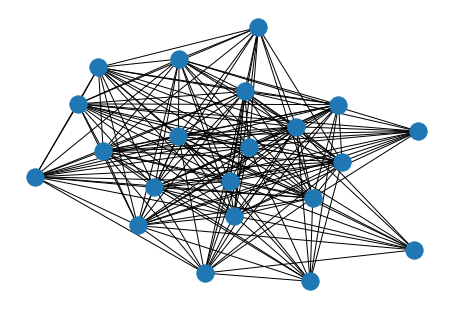

In [23]:
g=nx.Graph()
for i in actors:
    g.add_node(i)
for i in relations_actor:
    try:
        g.add_edge(*i)
    except:
        print("No Edges")
    
nx.draw(g)